In [1]:
%matplotlib inline

In [2]:
import matplotlib.pylab as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})

import numpy as np
from scipy.fftpack import rfft

In [3]:
from pdkit.gait_time_series import GaitTimeSeries
from pdkit.gait_processor import GaitProcessor
from pdkit.utils import butter_lowpass_filter, crossings_nonzero_pos2neg

/home/c/lab/envs/pdkit/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [4]:
ts = GaitTimeSeries.load_data('../tests/data/cloudupdrs_gait.csv')
gp = GaitProcessor()

In [5]:
ts.head()

,td,x,y,z,mag_sum_acc
1970-01-01 00:00:00.000000,0.000000,10.038197,0.694638,-0.299648,10.066663
1970-01-01 00:00:00.024536,0.024536,9.888372,0.694638,-0.272407,9.916483
1970-01-01 00:00:00.042755,0.042755,9.915613,0.653777,-0.272407,9.940876
1970-01-01 00:00:00.060761,0.060761,9.915613,0.612916,-0.299648,9.939056
1970-01-01 00:00:00.078766,0.078766,9.915613,0.612916,-0.231546,9.937236


In [6]:
strikes, strike_i = gp.heel_strikes(ts.x)

In [7]:
walking = ts[strike_i[0]: strike_i[-1]]
total_steps = len(walking)

steps = []

for z in range(len(strike_i) - 1):
    steps.append([ts.x[strike_i[z]: strike_i[z+1]]])

first_foot= [len(a[0]) for a in steps[::2]]
second_foot = [len(a[0])  for a in steps[1::2]]

first_sym = np.sum([a / total_steps for a in first_foot])
second_sym = np.sum([a / total_steps for a in second_foot])

np.sum(first_sym) + np.sum(second_sym)

1.0

In [8]:
f_gi = [a / gp.sampling_frequency for a in first_foot]
s_gi = [a / gp.sampling_frequency for a in second_foot]

In [9]:
np.mean([np.std(f_gi), np.std(s_gi)])

0.2026696444350172

In [10]:
the_fft = np.fft.fft(ts.x)

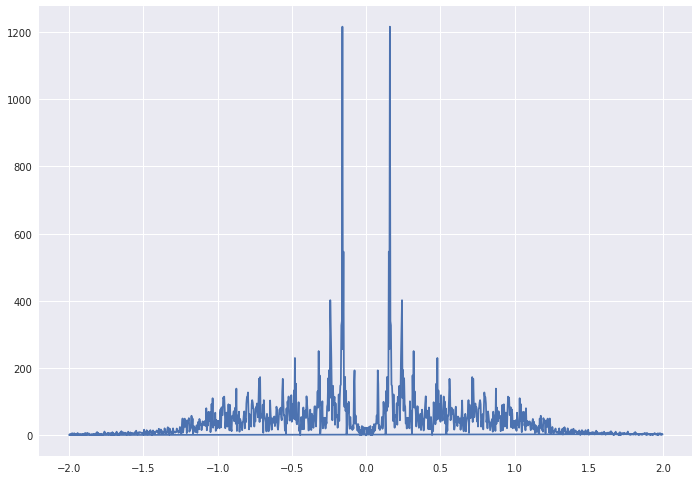

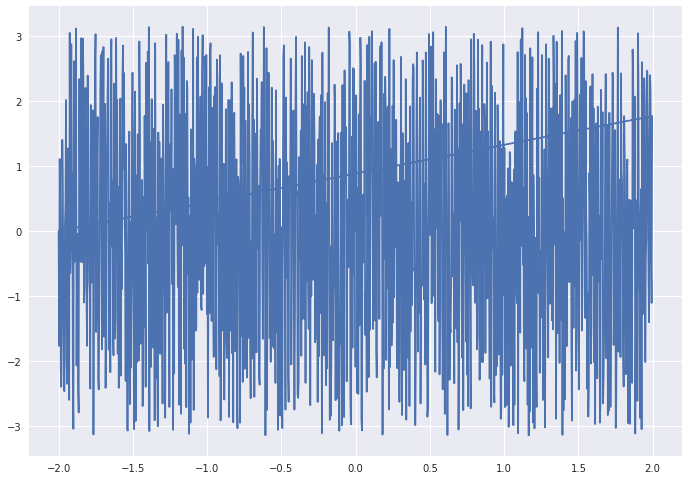

In [12]:
y = ts.x
Y = np.fft.fft(y)
freq = np.fft.fftfreq(len(y), 0.25)

plt.figure()
plt.plot( freq, np.abs(Y) )
plt.figure()
plt.plot(freq, np.angle(Y) )
plt.show()

In [13]:
h, e = np.histogram(Y, 100)

/home/c/lab/envs/pdkit/lib/python3.6/site-packages/numpy/lib/function_base.py:786: ComplexWarning: Casting complex values to real discards the imaginary part
  tmp_a_data = tmp_a.astype(float)
/home/c/lab/envs/pdkit/lib/python3.6/site-packages/numpy/lib/function_base.py:792: ComplexWarning: Casting complex values to real discards the imaginary part
  indices = tmp_a.astype(np.intp)


In [14]:
np.sum(h[::2]) / np.sum(h[1::2])

2.0765027322404372

In [15]:
np.sqrt(np.mean(ts.mag_sum_acc))

3.2018112511728054

In [16]:
first_foot

[49, 51, 51, 32, 71, 99, 52]

In [17]:
first_strides = list(zip(first_foot[::2], first_foot[1::2]))
second_strides = list(zip(second_foot[::2], second_foot[1::2]))

first_str_duration = [np.sum(a) / gp.sampling_frequency for a in first_strides]
second_str_duration = [np.sum(a) / gp.sampling_frequency for a in second_strides]

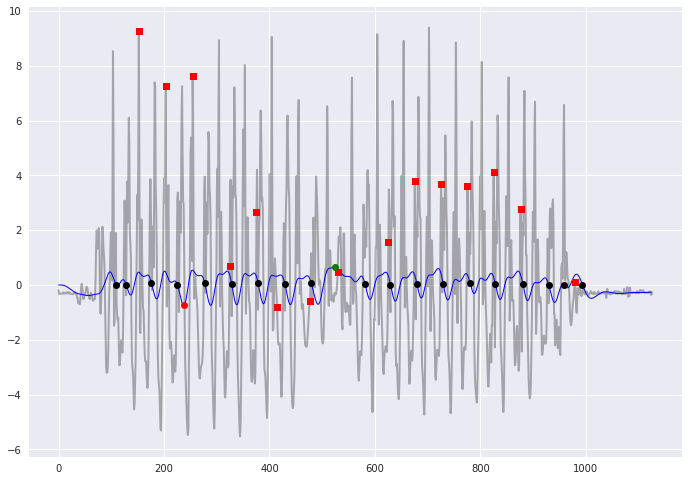

In [18]:
x = ts.mag_sum_acc

strikes, strike_indices = gp.heel_strikes(x)
data = x.values

filtered = butter_lowpass_filter(data, sample_rate=100.0, cutoff=2.0, order=4)
transitions = crossings_nonzero_pos2neg(filtered)
tplot = np.linspace(0, np.size(data), np.size(data))

top = [np.argmax(filtered), filtered[np.argmax(filtered)]]
bot = [np.argmin(filtered), filtered[np.argmin(filtered)]]

plt.plot(tplot, data, 'k-', linewidth=2, label='data', alpha=0.3)
plt.plot(tplot, filtered, 'b-', linewidth=1, label='filtered data')

plt.plot(tplot[transitions], filtered[transitions], 'ko', linewidth=1, label='transition points')
plt.plot(tplot[strike_indices], data[strike_indices], 'rs', linewidth=1, label='heel strikes')

plt.plot(top[0], top[1], 'go')
plt.plot(bot[0], bot[1], 'ro')

In [19]:
import scipy.signal as sig

In [29]:
def start_end_turn(f_sig, freq=100):
    
    gt = sig.argrelextrema(f_sig, np.greater)[0]
    lt = sig.argrelextrema(f_sig, np.less)[0]
    
    peaks = sorted(list(gt) + list(lt))

    top_peak = np.argmax(f_sig[peaks])
    bot_peak = np.argmin(f_sig[peaks])
    
    if top_peak > bot_peak:
        start_turn = peaks[bot_peak - 1]
        end_turn = peaks[top_peak + 1]
    else:
        start_turn = peaks[top_peak - 1]
        end_turn = peaks[bot_peak + 1]


    plt.plot(f_sig)
    plt.plot(start_turn, f_sig[start_turn], 'go')
    plt.plot(end_turn, f_sig[end_turn], 'ro')
    
    return start_turn, end_turn

Time it took to turn  0.89 seconds


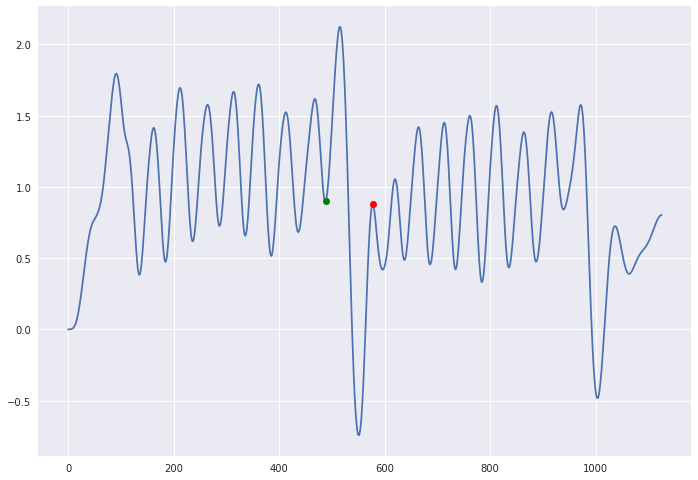

In [21]:
s_y, e_y = start_end_turn(ts.y)

Time it took to turn  1.22 seconds


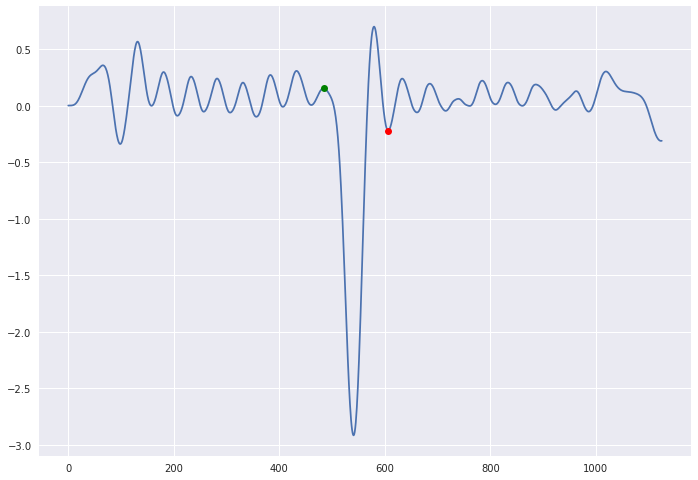

In [94]:
s_z, e_z = start_end_turn(ts.z)

2.95


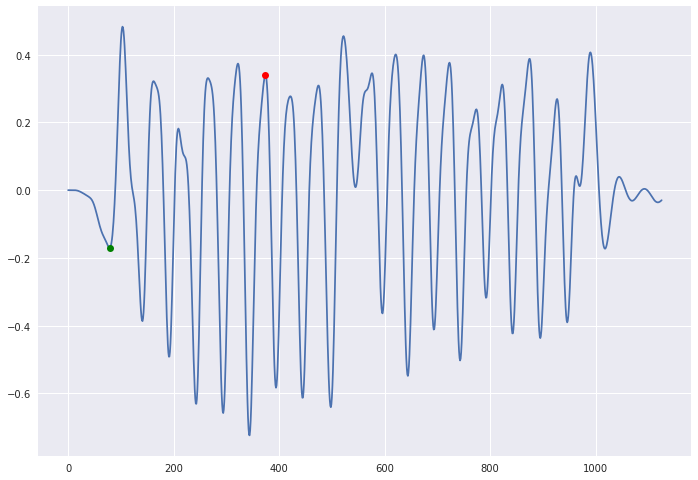

In [78]:
s_x, e_x = start_end_turn(ts.x)

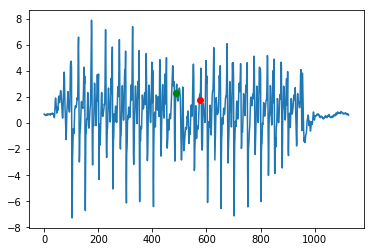

In [201]:
plt.plot(ts.y.values)
plt.plot(start_turn, ts.y[s], 'go')
plt.plot(end_turn, ts.y[e], 'ro')

In [42]:
def walk_turn_times(data, freq, verbose=False):
    signal = butter_lowpass_filter(data, freq, cutoff=2, order=5)
    
    start, end = start_end_turn(signal)
    
    forward = signal[:start]
    backward = signal[end:]
    turn = signal[start:end]
    
    time_f = len(forward) / freq
    time_b = len(backward) / freq
    time_t = len(turn) / freq
    
    if verbose:
        print("Time it took to walf forward: {} s".format(time_f))
        print("Time it took to turn: {} s".format(time_t))
        print("Time it took to walk backwards: {} s ".format(time_b))
    
    return time_f, time_t, time_b

In [43]:
def two_axis_turn_time(data, freq):
    f_y, t_y, b_y = walk_turn_times(data.y, freq)
    f_z, t_z, b_z = walk_turn_times(data.z, freq)
    
    f = np.mean([f_y, f_z])
    t = np.mean([t_y, t_z])
    b = np.mean([b_y, b_z])
    
    print("Time it took to walf forward: {} s".format(f))
    print("Time it took to turn: {} s".format(t))
    print("Time it took to walk backwards: {} s ".format(b))

Time it took to walf forward: 4.859999999999999 s
Time it took to turn: 1.055 s
Time it took to walk backwards: 5.345000000000001 s 


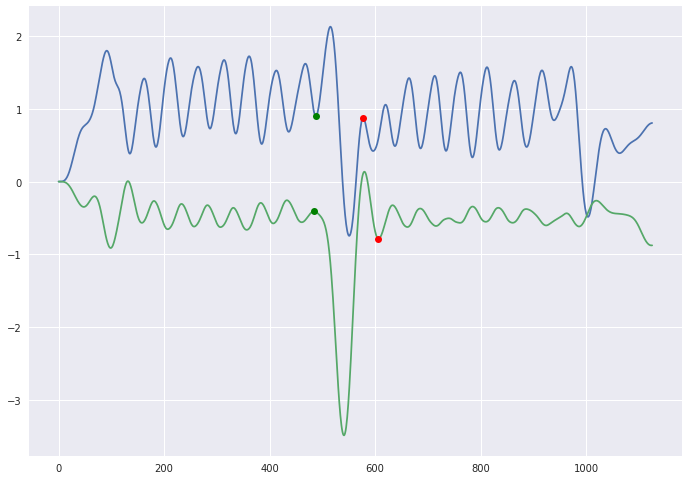

In [44]:
two_axis_turn_time(ts, 100)

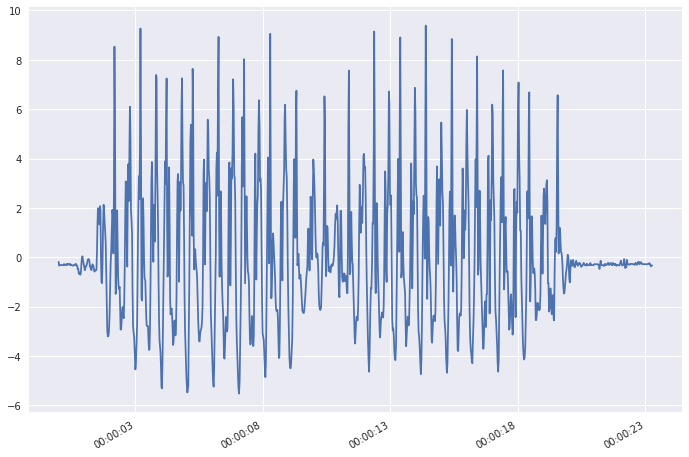

In [45]:
ts.mag_sum_acc.plot()